In [2]:
import os
from pathlib import Path
root = Path('/Users/user/Coding/EV-D68-3C-protease/')
os.chdir(root)
folder = Path('download/D68EV3CPROA')
assert folder.exists()

In [3]:
from plip.structure.preparation import PDBComplex, PLInteraction
    
for holo in (folder / Path('aligned')).glob('*/*.pdb'):
    plip_holo = PDBComplex()
    plip_holo.load_pdb(str(holo))
    plip_holo.analyze()
    break

In [8]:
from typing import List
    
intxn_name: str # 'LIG:A:201 .hetid + .chain .position of plip_holo.ligands[0]
intxn_set: PLInteraction
for intxn_name, intxn_set in plip_holo.interaction_sets.items():
    intxns: List = intxn_set.all_itypes
    break

In [5]:
intxn_name

'LIG:A:201'

In [10]:
intxns[0]

hydroph_interaction(bsatom=<openbabel.pybel.Atom object at 0x1177bff70>, bsatom_orig_idx=292, ligatom=<openbabel.pybel.Atom object at 0x117889810>, ligatom_orig_idx=1450, distance=3.8559312753211765, restype='VAL', resnr=34, reschain='A', restype_l='LIG', resnr_l=201, reschain_l='A')

## TEMP

For now I will annotate the extracted hits with reference. In future I will map atomically!

In [11]:
"""
https://github.com/matteoferla/PLIP-PyRosetta-hotspots-test/blob/main/plipspots_docking/plipspots/serial.py

This is a class I use to _apply_ PLIP to a pd.Series of molecules.
It is not built for the project, but works.
Note I have not dumped the methods that are not needed for the project.
"""

import os
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from functools import singledispatchmethod
from typing import Tuple, Dict, List, Union
from collections import Counter, defaultdict
from plip.structure.preparation import PDBComplex, PLInteraction
from openbabel.pybel import Atom, Residue
from openbabel.pybel import ob
from fragmenstein.victor import MinimalPDBParser
import warnings


class SerialPLIPper:
    """
    Calling the instance will return a ``Dict[Tuple[str, str, int], int]``,
    where the key is interaction type, residue 3-letter name, residue index
    and the value is the count of interactions.
    Basically, applying Plip to a pd.Series of Chem.Mol.

    Unplacking it is kind of wierd, the best way I reckon is a brutal for-loop:

    .. code-block:: python

        import pandas as pd
        import pandera.typing as pdt

        intxndexes: pdt.Series[Dict[Tuple[str, str, int], int]] = hits.ROMol.apply(SerialPLIPper(pdb_filename))
        # columns will still be a tuple...:
        intxn_df = pd.DataFrame(intxndexes.to_list()).fillna(0).astype(int)
        hits['N_interactions'] = intxn_df.sum(axis='columns')
        for c in sorted(intxn_df.columns, key=lambda kv: kv[2]):
            # columns will be a colon-separated string:
            hits[':'.join(map(str, c))] = intxn_df[c]
    """

    def __init__(self, pdb_block: str, resn='LIG', chain='B'):
        assert 'ATOM' in pdb_block, f'No ATOM entry in block provided: {pdb_block}'
        self.pdb_block = pdb_block
        self.resn = resn
        self.chain = chain

    @classmethod
    def from_filename(cls, pdb_filename: str, *args, **kwargs):
        """
        The main constructor is from PDB block, this is from PDB file
        """
        with open(pdb_filename, 'r') as f:
            pdb_block = f.read()
        return cls(pdb_block, *args, **kwargs)

    def __call__(self, mol) -> Dict[Tuple[str, str, int], int]:
        if mol is None or not isinstance(mol, Chem.Mol) or mol.GetNumAtoms() == 0:
            return {}
        holo: str = self.plonk(mol)
        interaction_set: PLInteraction = self.get_interaction_set(holo)
        return self.get_interaction_counts(interaction_set)

    def assign_pdb(self, mol: Chem.Mol):
        """
        Fix the PDB info for the molecule, in place
        """
        counts = defaultdict(int)
        atom: Chem.Atom
        for atom in mol.GetAtoms():
            element: str = atom.GetSymbol()
            counts[element] += 1
            info = Chem.AtomPDBResidueInfo(atomName=f'{element: >2}{counts[element]: <2}',
                                           residueName=self.resn,
                                           residueNumber=1, chainId=self.chain)
            atom.SetPDBResidueInfo(info)

    def plonk(self, mol):
        """
        Temporarily here. Do not copy.
        There likely is a way to do this in OBabel
        This is using Fragmenstein ``MinimalPDBParser``.

        :param mol:
        :return:
        """
        pdbdata = MinimalPDBParser(self.pdb_block, remove_other_hetatms=True, ligname=self.resn)
        self.assign_pdb(mol)
        moldata = MinimalPDBParser(Chem.MolToPDBBlock(mol))
        pdbdata.append(moldata)
        return str(pdbdata)

    @singledispatchmethod
    def get_interaction_set(self) -> PLInteraction:
        """
        Overloaded method: block or mol return the iternaction set
        :return:
        """
        raise NotImplementedError

    @get_interaction_set.register
    def _(self, block: str) -> PLInteraction:
        holo = PDBComplex()
        holo.load_pdb(block, as_string=True)
        holo.analyze()
        return holo.interaction_sets[':'.join([self.resn, self.chain, str(1)])]

    @get_interaction_set.register
    def _(self, mol: Chem.Mol) -> PLInteraction:
        if mol.GetNumAtoms() == 0:
            raise ValueError('Molecule has no atoms')
        holo = PDBComplex()
        holo.load_pdb(self.plonk(mol), as_string=True)
        holo.analyze()
        return holo.interaction_sets[':'.join([self.resn, self.chain, str(1)])]

    def get_atomname(self, atom: Union[Atom, ob.OBAtom]) -> str:
        """
        Given an atom, return its name.
        """
        if isinstance(atom, Atom):
            res: ob.OBResidue = atom.residue.OBResidue
            obatom = atom.OBAtom
        elif isinstance(atom, ob.OBAtom):
            obatom: ob.OBAtom = atom
            res: ob.OBResidue = obatom.GetResidue()
        else:
            raise TypeError
        return res.GetAtomID(obatom)

    def get_atom_by_atomname(self, residue: Union[ob.OBResidue, Residue], atomname: str) -> ob.OBAtom:
        """
        Get an atom by its name in a residue.
        """
        if isinstance(residue, Residue):
            residue = residue.OBResidue
        obatom: ob.OBAtom
        for obatom in ob.OBResidueAtomIter(residue):
            if residue.GetAtomID(obatom).strip() == atomname:
                return obatom
        else:
            raise ValueError(f'No atom with name {atomname} in residue {residue.GetName()}')

    def get_interaction_counts(self, interaction_set: PLInteraction) -> Dict[Tuple[str, str, int], int]:
        """
        Count the number of interactions of each type for each residue
        """
        intxns: List = interaction_set.all_itypes
        intxn_dex = defaultdict(int)
        for intxn in intxns:
            key = (intxn.__class__.__name__, intxn.restype, intxn.resnr)
            intxn_dex[key] += 1
        return dict(sorted(intxn_dex.items(), key=lambda kv: kv[0][2]))

In [13]:
## Import hits

from rdkit import Chem

with Chem.SDMolSupplier('hits.filtered.sdf') as sds:
    hits = list(sds)
    
hit_names = [hit.GetProp('_Name') for hit in hits]
hit_smileses = [Chem.MolToSmiles(hit) for hit in hits]
hitdex = dict(zip(hit_names, hits))

In [50]:
import pandas as pd
import pandera.typing as pdt

hit_table = pd.DataFrame({'mol': hitdex})

with open('reference.pdb') as fh:
    pdbblock = fh.read()

#intxndexes: pdt.Series[Dict[Tuple[str, str, int], int]] = hit_table.mol.apply(SerialPLIPper(pdbblock))
# columns will still be a tuple...:
intxn_df = pd.DataFrame(intxndexes.to_list()).fillna(0).astype(int)
intxn_df.index = hit_table.index
hit_table['N_interactions'] = intxn_df.sum(axis='columns')
for c in sorted(intxn_df.columns, key=lambda kv: kv[2]):
    # columns will be a colon-separated string:
    hit_table[':'.join(map(str, c))] = intxn_df[c]

In [52]:
del hit_table['mol']
hit_table.to_csv('hit-intxns.csv')

In [53]:
# Bond order is obtained via OBMol.PerceiveBondOrders()

<function rdkit.Chem.rdMolAlign.GetBestRMS>

In [56]:
hit_table.loc['x1594_0A§1']

N_interactions                 1
hbond:LYS:22                   0
hbond:GLU:24                   0
hbond:HIS:40                   0
hydroph_interaction:HIS:40     0
pistack:HIS:40                 0
hbond:ASN:69                   0
hbond:GLU:71                   0
saltbridge:GLU:71              0
hydroph_interaction:LYS:108    0
saltbridge:LYS:108             0
hydroph_interaction:LEU:127    0
hbond:GLY:128                  0
hbond:THR:130                  0
hydroph_interaction:THR:130    0
hbond:THR:142                  1
hydroph_interaction:ALA:144    0
hbond:ALA:144                  0
hbond:GLY:145                  0
halogenbond:CYS:147            0
hbond:CYS:147                  0
hbond:HIS:161                  0
hbond:VAL:162                  0
hbond:GLY:164                  0
hbond:ASN:165                  0
hbond:GLY:166                  0
Name: x1594_0A§1, dtype: int64

In [ ]:
HIS161 THR142

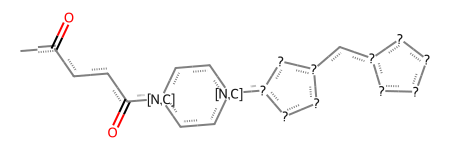

In [71]:
Chem.MolFromSmarts('CC(=O)CCC(=O)[N,C]3CC[N,C](a2aa(Ca1a[aH1][s,n,o;H0][s,n,o;H0]1)aa2)CC3')